+ 자료 준비
  + import 
  + data load : 7 day
  + Text to token : df_network
  + token 분류 :

+ 시각화 결과 비교
    + [ ] Word cloud
    + [x] Network : 지정 키워드 중심
        + [x] 기본 format
        + [ ] count(edge distance) 추가
    + [ ] Network : 특정 Category 중심
    + [ ] text rank 변화

+ 시각화 관점
    + [ ] 리뷰 점수별
    + [ ] 특정 분류


### import

In [1]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import os

# 그래프
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 시간기록
from datetime import datetime, timedelta
import time 
from dateutil.relativedelta import relativedelta

from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

import networkx as nx
from pyvis.network import Network

from collections import Counter
from wordcloud import WordCloud
from glob import glob
import os 
from google.cloud import bigquery


import warnings
warnings.filterwarnings("ignore")


C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


### data load

In [3]:
# 접속 정보 : BigQuery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./***************************************.json"
client = bigquery.Client()

# 접속 정보 : MySQL 
conn = pymysql.connect(host = '**.***.*.*', user ='__USER_ID__', password = "__PASSWORD__", database='__DATABASE__')
cursor = conn.cursor(pymysql.cursors.DictCursor)


def get_data(keyword1, keyword2):
    sql = """SELECT USER
             , FORMAT_DATETIME('%Y-%m-%d', CAST(A.DATE AS DATETIME)) as REG_DTM
             , FORMAT_DATETIME('%Y-%m', CAST(A.DATE AS DATETIME)) as REG_DT
             , FORMAT_DATETIME('%YY-%VW', CAST(A.DATE AS DATETIME)) as REG_WEEK
             , CHANNEL
             , PRODUCT
             , REVIEW
             , SCORE
             FROM `boxwood-*****************.review.review_all` A
             where PRODUCT like '%"""+keyword1+"""%'
             and PRODUCT like '%"""+keyword2+"""%'
             and CAST(A.DATE AS DATETIME) between DATE_SUB(current_date(), INTERVAL 90 DAY) and DATE_SUB(current_date(), INTERVAL -1 DAY)
             order by CAST(A.DATE AS DATETIME) desc"""
    df1 = client.query(sql).to_dataframe()
    df1 = df1.replace('kakaomakers', '카카오 선물하기')
    sql2=  '''select A.WRITER as USER
            , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as REG_DTM 
            , left((STR_TO_DATE(A.WRITE_DT, '%Y%m%d')),7)  as REG_DT 
            , DATE_FORMAT(STR_TO_DATE(A.WRITE_DT, '%Y%m%d'),'%YY-%uW' )  as REG_WEEK 
            , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as CHANNEL 
            , group_concat(distinct B.CODE_NM order by CODE_NM asc) as PRODUCT
            , A.GRADE as SCORE
            , trim(A.CONTENTS) as REVIEW
            FROM MAEIL_REVIEW A, JT_CODE B
            where A.GRADE in (1,2,3,4,5)
            and CAST(STR_TO_DATE(A.WRITE_DT, '%Y%m%d') AS DATETIME) between DATE_SUB(current_date(), INTERVAL 90 DAY) and DATE_SUB(current_date(), INTERVAL -1 DAY)
            and A.PRODUCT_CODE = B.CODE 
            AND B.CODE_NM like '%'''+keyword1 +'''%'
            AND B.CODE_NM like '%'''+keyword2 +'''%'
            and B.CODE not like'G_%'
            group by A.WRITER, A.WRITE_DT, A.COMPANY_CODE, GRADE, CONTENTS
            order by A.WRITE_DT desc
            '''
    cursor.execute(sql2)
    df2 = cursor.fetchall()
    df2 = pd.DataFrame(df2)
    df2 = df2.replace('25 카카오 톡스토어(20.12.2~미사용)', '25 카카오톡')
    df_t =  pd.concat([df1, df2], ignore_index=True)
    return df_t

In [4]:
category_group, category_keyword = '아이스크림', '100'
df1 =  get_data(category_group, category_keyword)

In [5]:
df1.PRODUCT.unique()

array(['[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ML ],[ 냉동 ] 상하아이스크림 [ 밀크 ] [ 컵 ] [ 100ML ]',
       '[ 냉동 ] 상하아이스크림 [ 밀크 ] [ 컵 ] [ 100ML ]',
       '[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ML ]'], dtype=object)

In [6]:
df = pd.concat([df1 ], ignore_index=True)
df['REG_DTM'] = pd.to_datetime(df['REG_DTM'],format = '%Y-%m-%d')
# df['REG_DTM'] = df['REG_DTM']
df.PRODUCT = df.PRODUCT.str.lower() 
df['SCORE'] = df['SCORE'].astype(float)
df['REVIEW'] = df['REVIEW'].str.replace('\n', ' ')
df['lenght'] = df['REVIEW'].str.len()
# df['REVIEW'] = df['REVIEW'].astype(object)

df = df[df.lenght != 0]
df = df.reset_index(drop=True)

In [7]:
df.groupby('CHANNEL').count()

,USER,REG_DTM,REG_DT,REG_WEEK,PRODUCT,REVIEW,SCORE,lenght
CHANNEL,,,,,,,,
3 네이버,1035,1035,1035,1035,1035,1035,1035,1035


In [8]:
df.REVIEW = df.REVIEW.str.replace('\x00', '')

In [9]:
df_neg = df[df['SCORE']<= 2]
df_pos = df[df['SCORE']>= 4]

In [10]:
def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()
    return str1

In [11]:
doc = listToString(df_pos[df_pos.REVIEW.str.contains(' ')]['REVIEW'])

In [12]:
# 사전에 고유 명사 추가
twitter.add_dictionary('콜드브루', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('오트밀크', 'Noun')
twitter.add_dictionary('종이빨대', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('서울우유', 'Noun')
twitter.add_dictionary('매일두유', 'Noun')
twitter.add_dictionary('바리스타', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('어메이징 오트', 'Noun')
twitter.add_dictionary('어메이징오트', 'Noun')
twitter.add_dictionary('언스위트', 'Noun')
twitter.add_dictionary('아몬드브리즈', 'Noun')
twitter.add_dictionary('아몬드 브리즈', 'Noun')
twitter.add_dictionary('오리지널', 'Noun')
twitter.add_dictionary('오리지날', 'Noun')
twitter.add_dictionary('언스윗트', 'Noun')
twitter.add_dictionary('의향', 'Noun')
twitter.add_dictionary('꿀맛', 'Noun')
twitter.add_dictionary('에스프레소', 'Noun')
twitter.add_dictionary('라떼', 'Noun')
twitter.add_dictionary('홈카페', 'Noun')
twitter.add_dictionary('바리스타', 'Noun')
twitter.add_dictionary('대용량', 'Noun')
twitter.add_dictionary('고소하', 'Noun')
twitter.add_dictionary('재발송', 'Noun')
twitter.add_dictionary('풍미', 'Noun')
twitter.add_dictionary('라테', 'Noun')
twitter.add_dictionary('에스프레스', 'Noun')
twitter.add_dictionary('큰팩', 'Noun')
twitter.add_dictionary('스벅', 'Noun')
twitter.add_dictionary('대용품', 'Noun')
twitter.add_dictionary('식물성', 'Noun')
twitter.add_dictionary('은은한', 'Noun')
twitter.add_dictionary('고소한', 'Noun')
twitter.add_dictionary('본연의', 'Noun')
twitter.add_dictionary('뽁뽁이', 'Noun')
twitter.add_dictionary('쇼핑백', 'Noun')
twitter.add_dictionary('브랜드데이', 'Noun')
twitter.add_dictionary('카톡딜', 'Noun')
twitter.add_dictionary('콘프라이트', 'Noun')
twitter.add_dictionary('달작지근하다', 'Verb')
twitter.add_dictionary('선식', 'Noun')
twitter.add_dictionary('고지혈', 'Noun')
twitter.add_dictionary('가성비', 'Noun')
twitter.add_dictionary('당뇨', 'Noun')
twitter.add_dictionary('찐한', 'Noun')
twitter.add_dictionary('홀더', 'Noun')
twitter.add_dictionary('투에프엘', 'Noun')
twitter.add_dictionary('분수토', 'Noun')
twitter.add_dictionary('셀렉스', 'Noun')
twitter.add_dictionary('화이버', 'Noun')
twitter.add_dictionary('장건강', 'Noun')
twitter.add_dictionary('장트러블', 'Noun')
twitter.add_dictionary('대변', 'Noun')
twitter.add_dictionary('배변', 'Noun')
twitter.add_dictionary('굿즈', 'Noun')
twitter.add_dictionary('문별', 'Noun')
twitter.add_dictionary('콤부차', 'Noun')
twitter.add_dictionary('레몬', 'Noun')

In [13]:
tokenized_doc = twitter.nouns(doc)

In [14]:
n_gram_range = (2, 2)
count = CountVectorizer(ngram_range=n_gram_range).fit([listToString(tokenized_doc)])
candidates = count.get_feature_names_out()
df_01 = pd.DataFrame(candidates)
df_01.rename(columns = {0 : 'text_0'}, inplace =True)
df_01['text_'] = df_01['text_0']
df_01 = pd.concat([df_01['text_'],df_01['text_0'].str.split(' ', expand=True)], axis=1)
df_01.rename(columns = {0 : 'from', 1 : 'to', }, inplace =True)

In [15]:
df1_wordcount.head(20)

NameError: name 'df1_wordcount' is not defined

In [276]:
net = Network(notebook=True)
G1 = nx.from_pandas_edgelist(df_01[df_01['from'] =='딸기'], 'from', 'to', create_using=nx.Graph())
G2 = nx.from_pandas_edgelist(df_01[df_01['from'] =='과일'], 'from', 'to', create_using=nx.Graph())
G3 = nx.from_pandas_edgelist(df_01[df_01['from'] =='과육'], 'from', 'to', create_using=nx.Graph())
G4 = nx.from_pandas_edgelist(df_01[df_01['from'] =='토핑'], 'from', 'to', create_using=nx.Graph())
G5 = nx.from_pandas_edgelist(df_01[df_01['from'] =='먹기'], 'from', 'to', create_using=nx.Graph())

net.from_nx(G1)
net.from_nx(G2)
net.from_nx(G3)
net.from_nx(G4)
net.from_nx(G5)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [277]:
# net.show_buttons(filter_=['physics'])
net.show("milk.html")

In [152]:
stopwords = ['어요', '오리', '어서', '하니', ]

In [153]:
for word in tokenized_doc:  # iterating on a copy since removing will mess things up
    if word in stopwords:
        tokenized_doc.remove(word)

In [242]:
def df_to_network(token_list, keyword):
    n_gram_range = (2, 2)
    count = CountVectorizer(ngram_range=n_gram_range).fit([listToString(token_list)])
    candidates = count.get_feature_names_out()
    df_01 = pd.DataFrame(candidates)
    df_01.rename(columns = {0 : 'text_0'}, inplace =True)
    df_01['text_'] = df_01['text_0']
    df_01 = pd.concat([df_01['text_'],df_01['text_0'].str.split(' ', expand=True)], axis=1)
    df_01.rename(columns = {0 : 'from', 1 : 'to', }, inplace =True)
    
    mpl.rc('figure', figsize=(7, 7), facecolor='#eeeeee' )
    G = nx.from_pandas_edgelist(df_01[df_01['from'] ==keyword], 'from', 'to', create_using=nx.Graph())
    color_map = []
    for node in G:
        if node == keyword:
            color_map.append('#FF8EBA')
        else: 
            color_map.append('#33A8FF')
    nx.draw(G, node_color=color_map, with_labels=True, edgecolors='gray', font_family=font_name, node_size = 1500, node_shape ='o')
    plt.title('[{}] 키워드의 연관단어 (Top 25)'.format(keyword),fontsize='x-large')
    plt.show()
    return 

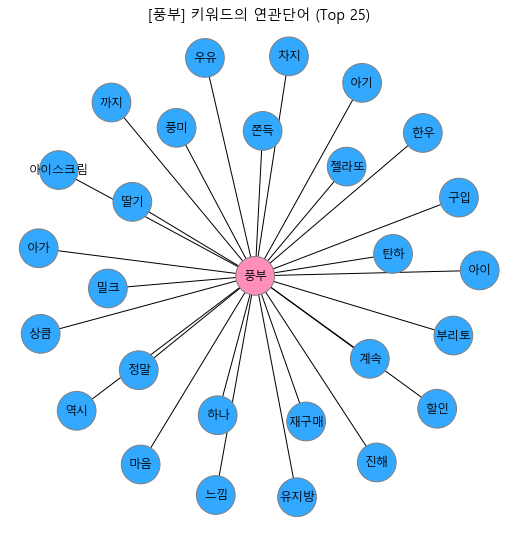

In [255]:
df_to_network(tokenized_doc, '풍부')

In [280]:
net = Network(notebook=True)
G1 = nx.from_pandas_edgelist(df_01[df_01['from'] =='밀크'], 'from', 'to', create_using=nx.Graph())
G2 = nx.from_pandas_edgelist(df_01[df_01['from'] =='풍부'], 'from', 'to', create_using=nx.Graph())
G3 = nx.from_pandas_edgelist(df_01[df_01['from'] =='아포가토'], 'from', 'to', create_using=nx.Graph())
G4 = nx.from_pandas_edgelist(df_01[df_01['from'] =='고급'], 'from', 'to', create_using=nx.Graph())
G5 = nx.from_pandas_edgelist(df_01[df_01['from'] =='쫀득'], 'from', 'to', create_using=nx.Graph())

net.from_nx(G1)
net.from_nx(G2)
net.from_nx(G3)
net.from_nx(G4)
net.from_nx(G5)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [281]:
net.show("icecream_2.html")

In [282]:
def df_to_network(token_list, keyword):
    n_gram_range = (2, 2)
    count = CountVectorizer(ngram_range=n_gram_range).fit([listToString(token_list)])
    candidates = count.get_feature_names_out()
    df_01 = pd.DataFrame(candidates)
    df_01.rename(columns = {0 : 'text_0'}, inplace =True)
    df_01['text_'] = df_01['text_0']
    df_01 = pd.concat([df_01['text_'],df_01['text_0'].str.split(' ', expand=True)], axis=1)
    df_01.rename(columns = {0 : 'from', 1 : 'to', }, inplace =True)
    
    mpl.rc('figure', figsize=(7, 7), facecolor='#eeeeee' )
    G = nx.from_pandas_edgelist(df_01[df_01['from'] ==keyword], 'from', 'to', create_using=nx.Graph())
    color_map = []
    for node in G:
        if node == keyword:
            color_map.append('#8EE5FF')
        else: 
            color_map.append('#33A8FF')
    nx.draw(G, node_color=color_map, with_labels=True, edgecolors='gray', font_family=font_name, node_size = 1500, node_shape ='o')
    plt.title('[{}] 키워드의 연관단어'.format(keyword),fontsize='x-large')
    plt.show()
    return 

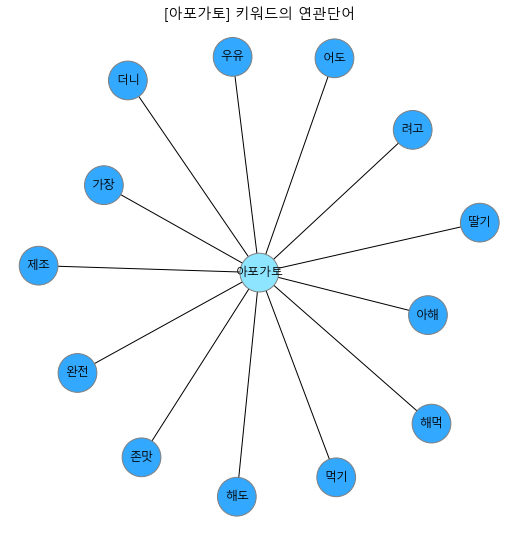

In [285]:
df_to_network(tokenized_doc, '아포가토')

In [144]:
def df_to_network2(token_list, keyword_list):
    n_gram_range = (2, 2)
    count = CountVectorizer(ngram_range=n_gram_range).fit([listToString(token_list)])
    candidates = count.get_feature_names_out()
    df_01 = pd.DataFrame(candidates)
    df_01.rename(columns = {0 : 'text_0'}, inplace =True)
    df_01['text_'] = df_01['text_0']
    df_01 = pd.concat([df_01['text_'],df_01['text_0'].str.split(' ', expand=True)], axis=1)
    df_01.rename(columns = {0 : 'from', 1 : 'to', }, inplace =True)
    pattern = '|'.join(keyword_list)
    df_01 = df_01[df_01['text_'].str.contains(pattern, case=False)].reset_index(drop=True)
    
    mpl.rc('figure', figsize=(15, 15), facecolor='#eeeeee' )
    G = nx.from_pandas_edgelist(df_01, 'from', 'to', create_using=nx.Graph())
    nx.draw(G, with_labels=True, edgecolors='gray', font_family=font_name, node_size = 2000, node_shape ='o')
    plt.title('[{}] 키워드의 연관단어 (Top 25)'.format(keyword_list[0]),fontsize='x-large')
    plt.show()
    return 

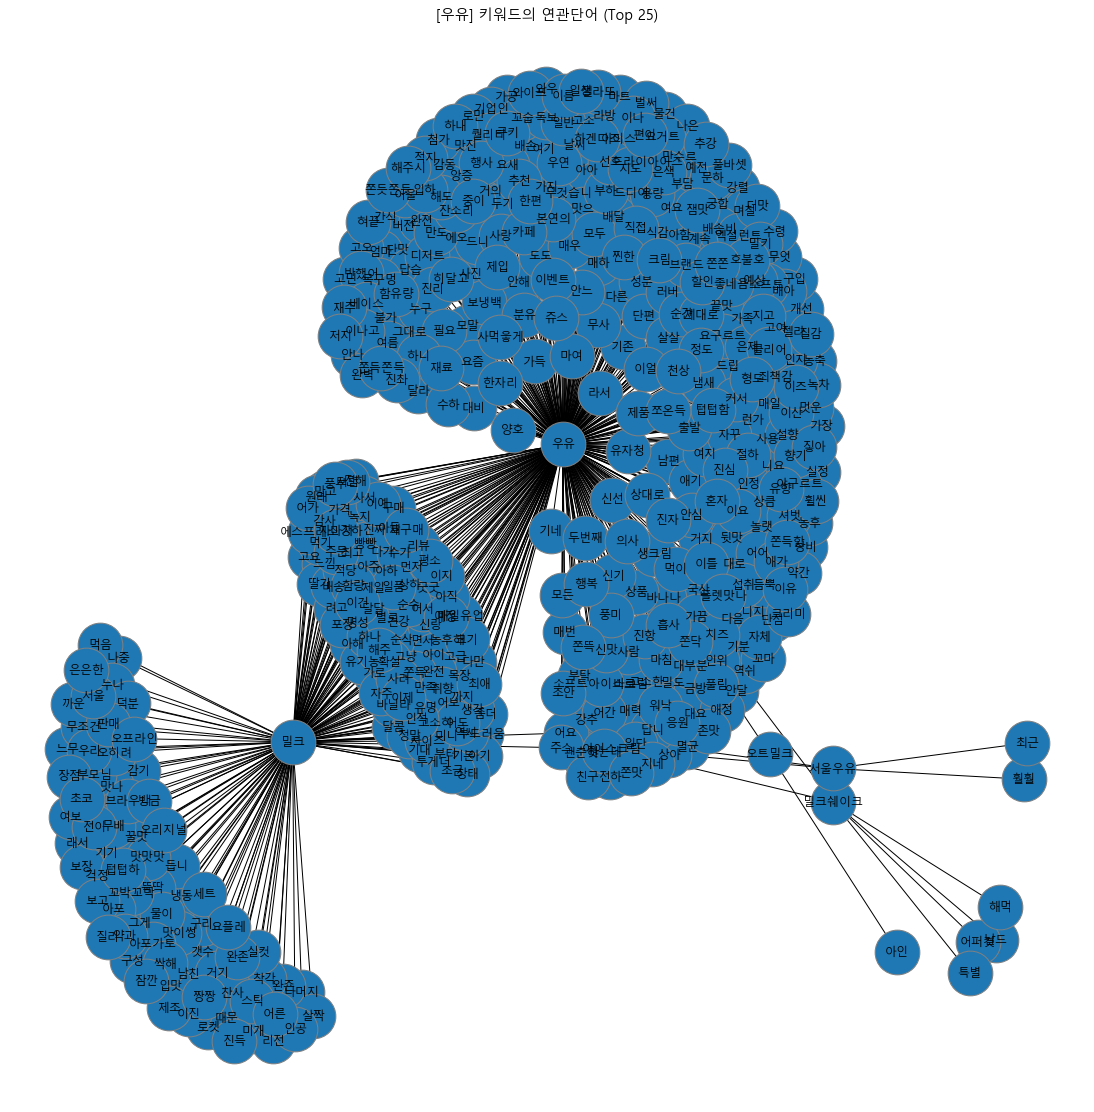

In [145]:
df_to_network2(tokenized_doc, ['우유', '밀크'])

In [167]:
wordfreq = {}
for word in listToString(tokenized_doc).replace(', ',' ').split():
    wordfreq[word] = wordfreq.setdefault(word, 0) + 1
    
df1_wordcount = pd.DataFrame.from_dict([wordfreq]).T.reset_index()
df1_wordcount.rename(columns = {0 : 'count', 'index' : 'words'}, inplace =True)
df1_wordcount = df1_wordcount.sort_values(by = 'count', axis=0, ascending=False).reset_index()
df1_wordcount = df1_wordcount[['words', 'count']]

df1_wordcount['LEN'] = df1_wordcount['words'].str.len()
df1_wordcount = df1_wordcount[df1_wordcount['LEN'] >= 2]

In [170]:
def get_colordict(palette,number,start):
    pal = list(sns.color_palette(palette=palette, n_colors=number).as_hex())
    color_d = dict(enumerate(pal, start=start))
    return color_d

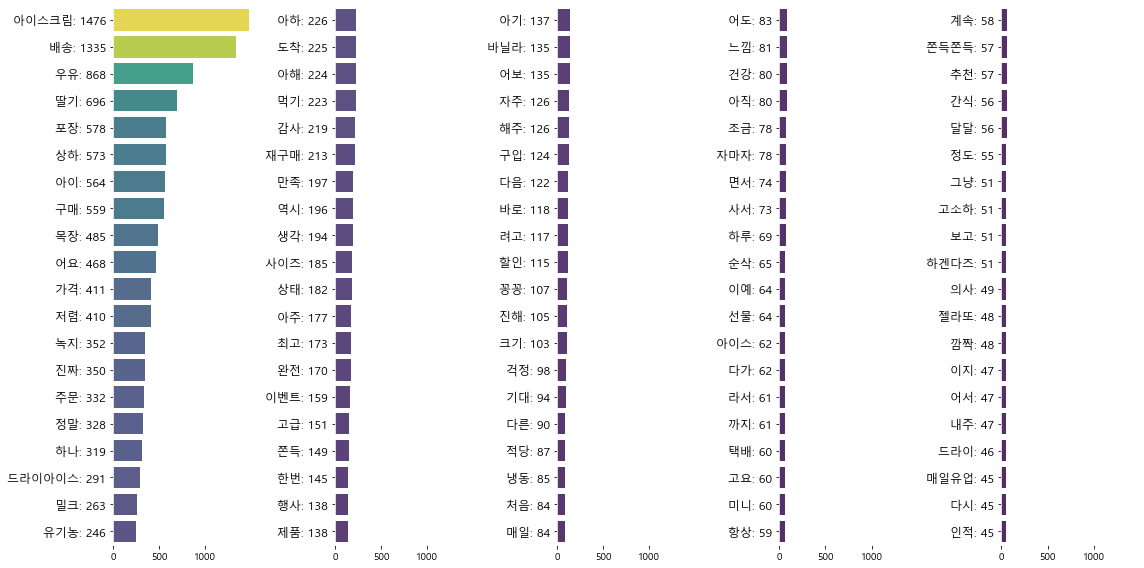

In [171]:
#create index list for slicing
index_list = [[i[0],i[-1]+1] for i in np.array_split(range(100), 5)]

n = df1_wordcount['count'].max()
color_dict = get_colordict('viridis', n, 1)

fig, axs = plt.subplots(1, 5, figsize=(16,8), facecolor='white', squeeze=False)
for col, idx in zip(range(0,5), index_list):
    df_temp = df1_wordcount[idx[0]:idx[-1]]
    label = [w + ': ' + str(n) for w,n in zip(df_temp['words'],df_temp['count'])]
    color_l = [color_dict.get(i) for i in df_temp['count']]
    x = list(df_temp['count'])
    y = list(range(0,20))
    
    sns.barplot(x = x, y = y, data=df_temp, alpha=0.9, orient = 'h', ax = axs[0][col], palette = color_l)
    axs[0][col].set_xlim(0,n+1)                     #set X axis range max
    axs[0][col].set_yticklabels(label, fontsize=12)
    axs[0][col].spines['bottom'].set_color('white')
    axs[0][col].spines['right'].set_color('white')
    axs[0][col].spines['top'].set_color('white')
    axs[0][col].spines['left'].set_color('white')
            
plt.tight_layout()    
plt.show()

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

import networkx as nx
from pyvis.network import Network
import nltk

In [23]:
def df_to_network2(dataset, keyword, stop_word, keyword_dt, threshold):
    tokenized_doc = twitter.pos(listToString(dataset['REVIEW'].str.replace('\n', ' ')), norm=False, stem=True)
    tokenized_nouns = [] 
    tokenized_nouns += ([word[0] for word in tokenized_doc if (word[1] == 'Noun') | (word[1] == 'Adjective')])
    
    #nltk 
    bigrams = nltk.bigrams(tokenized_nouns)
    frequence = nltk.FreqDist(bigrams)
    
    # DataFrame
    df_01 = pd.DataFrame.from_dict([frequence]).T.reset_index().sort_values(by = 0, ascending = False)
    df_01['From'] = df_01['index'].str[0]
    df_01['To'] = df_01['index'].str[1] 
    df_01['From_LEN'] = df_01['From'].str.len()
    df_01 = df_01[df_01['From_LEN'] >= 2]
    df_01['To_LEN'] = df_01['To'].str.len()
    df_01 = df_01[df_01['To_LEN'] >= 2]
    df_01.rename(columns = {0 : 'weight'}, inplace =True)
    df_01 = df_01[['From', 'To', 'weight']].reset_index(drop=True)
    df_01 = df_01[df_01['weight']>= threshold]
    for t_ in stop_word:
        df_01 = df_01[~(df_01['From'].str.contains(t_) | df_01['To'].str.contains(t_) ) ]
    
    df_t = df_01[df_01['From']==keyword].reset_index(drop=True)
    sec_list = list(df_01[df_01['From']==keyword]['To'])
    for k in sec_list:
        df_a = df_01[df_01['From']==k].reset_index(drop=True)
        df_t = df_t.append(df_a)
    
    mpl.rc('figure', figsize=(20, 20), facecolor='#eeeeee' )
    G = nx.from_pandas_edgelist(df_t, 'From', 'To',  edge_attr=["weight"], create_using=nx.Graph())
    color_map = []
    node_size = [] 
    for node in G:
        if node == keyword:
            color_map.append('#c8cbcc')
            node_size.append(2000)
        elif node in pos_word:
            color_map.append('#FF8EBA')
            node_size.append(700)
        else:
            color_map.append('#33A8FF')
            node_size.append(700)
    nx.draw_networkx(G, node_color=color_map, with_labels=True, edgecolors='gray', font_family=font_name, 
                     node_size = node_size, node_shape ='o', width = list(df_t['weight']*0.2) )
    plt.title('[{}] 키워드의 연관단어* : {} 기준'.format(keyword, keyword_dt),fontsize='x-large')
    return

In [33]:
df_01.head(10)

,text_,from,to
0,가게 상하,가게,상하
1,가격 가격,가격,가격
2,가격 가성비,가격,가성비
3,가격 감사,가격,감사
4,가격 건강,가격,건강
5,가격 구매,가격,구매
6,가격 구입,가격,구입
7,가격 대가,가격,대가
8,가격 대비,가격,대비
9,가격 딸기,가격,딸기


In [25]:
# doc_time = end_wt
stop_word = ['어요', '어서', '해주', '있다', '하니', '까지', '라서' , '고배', '먹기', '없다', '아해', '은제', '아하', '기전', '이다', 
             '같다', '아주']

pos_word = ['감사', '빠르다', '빨르다', '좋다', '만족', '깔끔하다', '감동' , '짧다', '길다', '넉넉하다', '관찮다',
            '저렴', '착하다', '많다', '특템',  '튼튼하다', '괜찮다', '훌륭하다', '편하다', '괜찮다', '재구매']

In [30]:
df

,USER,REG_DTM,REG_DT,REG_WEEK,CHANNEL,PRODUCT,REVIEW,SCORE,lenght
0,miso*****,2023-03-05,2023-03,2023Y-09W,3 네이버,"[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ml ],[ 냉동 ] 상...",맛있어서 재구매합니다.,5.0,12
1,ncnd***,2023-03-05,2023-03,2023Y-09W,3 네이버,"[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ml ],[ 냉동 ] 상...",너무 맛나요 편의점 1+1으로 처음 맛본 후부터 이것만 먹어요,5.0,34
2,ccm9***,2023-03-05,2023-03,2023Y-09W,3 네이버,"[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ml ],[ 냉동 ] 상...",맛잇러요 부드럽구료,4.0,10
3,jj****,2023-03-05,2023-03,2023Y-09W,3 네이버,"[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ml ],[ 냉동 ] 상...",커피나 딸기라떼 타먹을때 유용하게 쓰고 있오요,5.0,25
4,317d****,2023-03-04,2023-03,2023Y-09W,3 네이버,"[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ml ],[ 냉동 ] 상...",양이 작아요 엉엉엉 나의한입ㄱㅓ리,4.0,18
...,...,...,...,...,...,...,...,...,...
1030,wnsq******,2022-12-06,2022-12,2022Y-49W,3 네이버,"[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ml ],[ 냉동 ] 상...",믿고 오는 곳인데 자주 이용합니다 무료배송 서비스가 굿입니다,5.0,33
1031,ahre******,2022-12-06,2022-12,2022Y-49W,3 네이버,[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ml ],맛은 말이 필요 없습니다.포장도 꼼꼼해서 녹지않게 잘 받았습니다.,5.0,36
1032,gori*****,2022-12-06,2022-12,2022Y-49W,3 네이버,"[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ml ],[ 냉동 ] 상...",선물해줬는데 좋아하네요!ㅎㅎ,5.0,15
1033,hjlo****,2022-12-06,2022-12,2022Y-49W,3 네이버,[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ml ],너무 맛있어서 또 주문했어요 친구도 사줬어요,5.0,24


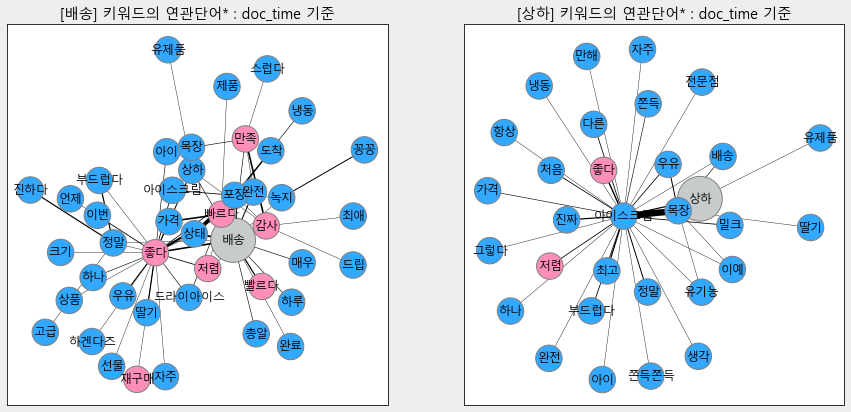

In [35]:
# (none)
mpl.rc('figure', figsize=(15,7))
plt.subplot(1,2,1)
df_to_network2(df, '배송', stop_word, 'doc_time', 2)

plt.subplot(1,2,2)
df_to_network2(df, '상하', stop_word, 'doc_time', 2)
plt.show()